In [1]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def load_training():
    images = np.load(os.path.join('../Data_final_fullver', 'X_train.npy'))
    labels = np.load(os.path.join('../Data_final_fullver', 'train_labels1_num.npy'))
    filenames = np.load(os.path.join('../Data_final_fullver', 'CBIS_train_FNs.npy'))
    return images, labels, filenames


def load_testing():
    images = np.load(os.path.join('../Data_final_fullver', 'X_test.npy'))
    labels = np.load(os.path.join('../Data_final_fullver', 'test_labels1_num.npy'))
    filenames = np.load(os.path.join('../Data_final_fullver', 'CBIS_test_FNs.npy'))
    return images, labels, filenames

In [3]:
train_images, train_labels, Fn= load_training()
test_images, test_labels, Fn= load_testing()

n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2925 	 Test size: 643
Image size: 256x256


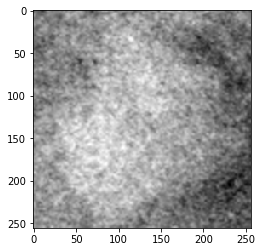

Label: 1
FN: Mass-Training_P_00106_LEFT_CC.png


In [4]:
idx = 10

plt.imshow(test_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(test_labels[idx]))
print("FN: " + str(Fn[idx]))

In [5]:
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [6]:
train_images.shape

(2925, 256, 256, 1)

In [7]:
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [8]:
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [9]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [10]:
train_datagen.fit(train_images)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

preprocess_input(test_images);

In [11]:
def create_vgg16(verbose=False, fc_size=256, output = 4, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(1024, activation='relu'))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(output, activation='softmax'))

    vgg16_base.trainable = False
    
    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

In [12]:
vgg = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
for layer in vgg.layers:
    layer.trainable = False
vgg_maxpool = vgg.get_layer('block5_pool').output
FeatureFlatten = Flatten()(vgg_maxpool)
dense1 = Dense(1024, name = 'dense1', activation = 'relu')(FeatureFlatten)
dense2 = Dense(128, name = 'dense2', activation = 'relu')(dense1)
predictions = Dense(2, name = 'predictions', activation = 'softmax')(dense2)

new_vgg = Model(inputs = vgg.input, outputs = predictions)
new_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [14]:
vgg16_calc_or_mass_best_Adam = new_vgg

In [15]:
vgg16_calc_or_mass_best_RMSprop = new_vgg

In [22]:
vgg16_calc_or_mass_best_Adam = create_vgg16(dropout=0.5, fc_size=128, output = 2)

In [23]:
vgg16_calc_or_mass_best_Adam.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 48,401,602
Trainable params: 33,686,914
Non-trainable params: 14,714,688
___________________________________

### Adam

In [16]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_calc_or_mass_best_Adam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_calc_or_mass_best_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [17]:
# Train
history_vgg16_calc_or_mass_best_Adam = vgg16_calc_or_mass_best_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0124 - recall: 0.6469
Epoch 00001: val_loss improved from inf to 0.57590, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adam.h5
11/11 [==============================] - 25s 2s/step - loss: 0.9781 - recall: 0.6534 - val_loss: 0.5759 - val_recall: 0.7573
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5717 - recall: 0.7483
Epoch 00002: val_loss improved from 0.57590 to 0.45432, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adam.h5
11/11 [==============================] - 20s 2s/step - loss: 0.5668 - recall: 0.7523 - val_loss: 0.4543 - val_recall: 0.7915
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4992 - recall: 0.7828
Epoch 00003: val_loss improved from 0.45432 to 0.44681, sa

Epoch 27/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2943 - recall: 0.8805
Epoch 00027: val_loss did not improve from 0.31940
11/11 [==============================] - 20s 2s/step - loss: 0.2973 - recall: 0.8746 - val_loss: 0.3261 - val_recall: 0.8462
Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3401 - recall: 0.8476
Epoch 00028: val_loss did not improve from 0.31940
11/11 [==============================] - 21s 2s/step - loss: 0.3325 - recall: 0.8541 - val_loss: 0.3864 - val_recall: 0.8171
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3405 - recall: 0.8586
Epoch 00029: val_loss did not improve from 0.31940
11/11 [==============================] - 22s 2s/step - loss: 0.3302 - recall: 0.8629 - val_loss: 0.3822 - val_recall: 0.8291
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3368 - recall: 0.8476
Epoch 00030: val_loss did not improve from 0.31940
11/11 [==============================] - 20s 

In [18]:
models.save_model(vgg16_calc_or_mass_best_Adam, '../model/vgg16_calc_or_mass_end_Adam.h5')

In [19]:
tra_loss_fe = history_vgg16_calc_or_mass_best_Adam.history['loss']
tra_acc_fe = history_vgg16_calc_or_mass_best_Adam.history['recall']
val_loss_fe = history_vgg16_calc_or_mass_best_Adam.history['val_loss']
val_acc_fe = history_vgg16_calc_or_mass_best_Adam.history['val_recall']

In [20]:
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_calc_or_mass = models.load_model('../model/vgg16_calc_or_mass_best_Adam.h5')
test_loss_fe, test_acc_fe = vgg16_calc_or_mass_best_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

In [21]:
print("VGG16 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 66
Epoch [opt]: 36
Valid accuracy [end]: 0.8444
Valid accuracy [opt]: 0.8496
Test accuracy [end]:  0.8771
Test accuracy [opt]:  0.8911
Valid loss [end]: 0.3419
Valid loss [opt]: 0.3027
Test loss [end]:  0.3107
Test loss [opt]:  0.3101


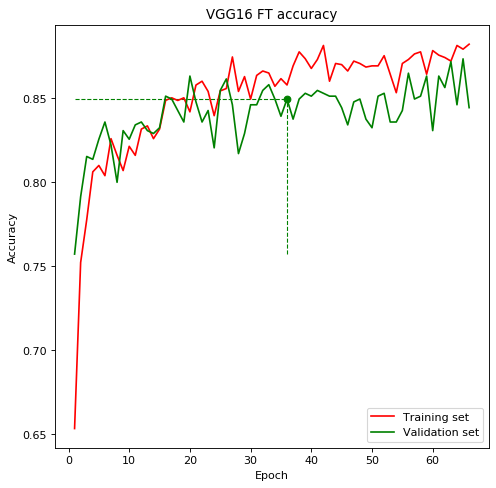

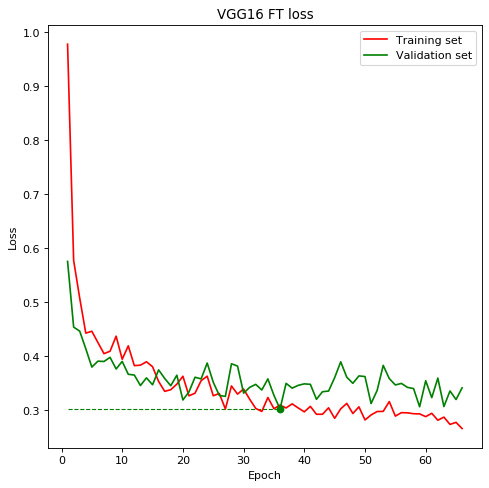

In [22]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### SGD

In [23]:
vgg16_calc_or_mass_best_SGD = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_calc_or_mass_best_SGD.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_calc_or_mass_best_SGD.compile(optimizer=optimizers.SGD(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [24]:
# Train
history_vgg16_calc_or_mass_best_SGD = vgg16_calc_or_mass_best_SGD.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4826 - recall: 0.5430
Epoch 00001: val_loss improved from inf to 1.09468, saving model to ../model/vgg16_mass_benign_or_malignant_best_SGD.h5
11/11 [==============================] - 21s 2s/step - loss: 1.4851 - recall: 0.5398 - val_loss: 1.0947 - val_recall: 0.5590
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2620 - recall: 0.5469
Epoch 00002: val_loss improved from 1.09468 to 0.91900, saving model to ../model/vgg16_mass_benign_or_malignant_best_SGD.h5
11/11 [==============================] - 21s 2s/step - loss: 1.2486 - recall: 0.5483 - val_loss: 0.9190 - val_recall: 0.6034
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1856 - recall: 0.5488
Epoch 00003: val_loss improved from 0.91900 to 0.77301, saving model to ../model/vgg16_mass_benign_or_malignant_best_SGD.h5
11/11 [=====

Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8293 - recall: 0.6650
Epoch 00029: val_loss did not improve from 0.64034
11/11 [==============================] - 21s 2s/step - loss: 0.8439 - recall: 0.6710 - val_loss: 0.6817 - val_recall: 0.7077
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8357 - recall: 0.7029
Epoch 00030: val_loss improved from 0.64034 to 0.61707, saving model to ../model/vgg16_mass_benign_or_malignant_best_SGD.h5
11/11 [==============================] - 21s 2s/step - loss: 0.8290 - recall: 0.6983 - val_loss: 0.6171 - val_recall: 0.7265
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9319 - recall: 0.6820
Epoch 00031: val_loss did not improve from 0.61707
11/11 [==============================] - 22s 2s/step - loss: 0.9228 - recall: 0.6797 - val_loss: 0.6743 - val_recall: 0.7282
Epoch 32/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8144 - recall: 0.6700
Epoch 00032: val_loss d

Epoch 88/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6957 - recall: 0.7247
Epoch 00088: val_loss did not improve from 0.49805
11/11 [==============================] - 21s 2s/step - loss: 0.7060 - recall: 0.7226 - val_loss: 0.5827 - val_recall: 0.7111
Epoch 89/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6631 - recall: 0.7138
Epoch 00089: val_loss did not improve from 0.49805
11/11 [==============================] - 21s 2s/step - loss: 0.6627 - recall: 0.7150 - val_loss: 0.5914 - val_recall: 0.7299
Epoch 90/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6560 - recall: 0.7352
Epoch 00090: val_loss did not improve from 0.49805
11/11 [==============================] - 22s 2s/step - loss: 0.6558 - recall: 0.7386 - val_loss: 0.5441 - val_recall: 0.7504
Epoch 91/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6506 - recall: 0.7227
Epoch 00091: val_loss did not improve from 0.49805
11/11 [==============================] - 22s 

In [25]:
models.save_model(vgg16_calc_or_mass_best_SGD, '../model/vgg16_calc_or_mass_end_SGD.h5')

In [26]:
tra_loss_fe = history_vgg16_calc_or_mass_best_SGD.history['loss']
tra_acc_fe = history_vgg16_calc_or_mass_best_SGD.history['recall']
val_loss_fe = history_vgg16_calc_or_mass_best_SGD.history['val_loss']
val_acc_fe = history_vgg16_calc_or_mass_best_SGD.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_calc_or_mass = models.load_model('../model/vgg16_calc_or_mass_best_SGD.h5')
test_loss_fe, test_acc_fe = vgg16_calc_or_mass_best_SGD.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG16 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 112
Epoch [opt]: 82
Valid accuracy [end]: 0.7419
Valid accuracy [opt]: 0.7761
Test accuracy [end]:  0.7698
Test accuracy [opt]:  0.7745
Valid loss [end]: 0.5639
Valid loss [opt]: 0.4981
Test loss [end]:  0.5423
Test loss [opt]:  0.5583


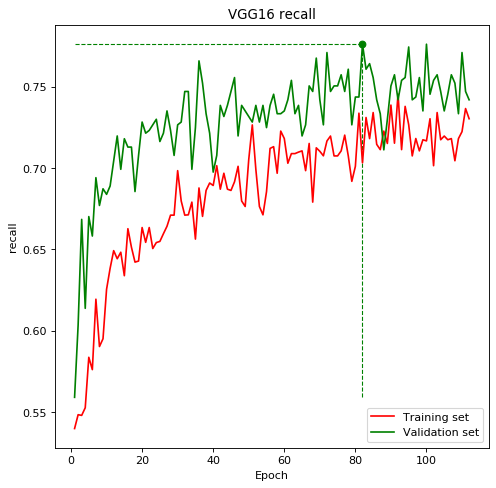

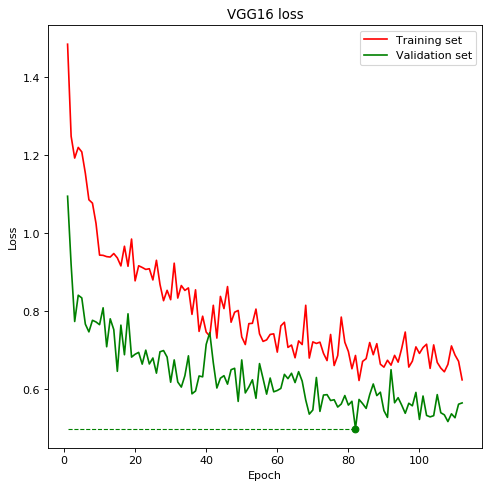

In [27]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 recall')
plt.ylabel('recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### RMSprop

In [28]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_calc_or_mass_best_RMSprop.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_calc_or_mass_best_RMSprop.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [29]:
# Train
history_vgg16_calc_or_mass_best_RMSprop = vgg16_calc_or_mass_best_RMSprop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4858 - recall: 0.8098
Epoch 00001: val_loss improved from inf to 0.34431, saving model to ../model/vgg16_mass_benign_or_malignant_best_RMSprop.h5
11/11 [==============================] - 21s 2s/step - loss: 0.4750 - recall: 0.8100 - val_loss: 0.3443 - val_recall: 0.8530
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2961 - recall: 0.8645
Epoch 00002: val_loss did not improve from 0.34431
11/11 [==============================] - 21s 2s/step - loss: 0.2973 - recall: 0.8663 - val_loss: 0.3546 - val_recall: 0.8598
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3175 - recall: 0.8617
Epoch 00003: val_loss did not improve from 0.34431
11/11 [==============================] - 22s 2s/step - loss: 0.3224 - recall: 0.8636 - val_loss: 0.3637 - val_recall: 0.8376
Epoch 4/300
10/11 [==========

Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2894 - recall: 0.8750
Epoch 00030: val_loss did not improve from 0.31258
11/11 [==============================] - 22s 2s/step - loss: 0.2901 - recall: 0.8764 - val_loss: 0.4232 - val_recall: 0.8291
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2729 - recall: 0.8836
Epoch 00031: val_loss did not improve from 0.31258
11/11 [==============================] - 22s 2s/step - loss: 0.2849 - recall: 0.8771 - val_loss: 0.3612 - val_recall: 0.8359
Epoch 32/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2888 - recall: 0.8750
Epoch 00032: val_loss did not improve from 0.31258
11/11 [==============================] - 21s 2s/step - loss: 0.2876 - recall: 0.8736 - val_loss: 0.3811 - val_recall: 0.8786
Epoch 33/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2938 - recall: 0.8797
Epoch 00033: val_loss did not improve from 0.31258
11/11 [==============================] - 20s 

In [30]:
models.save_model(vgg16_calc_or_mass_best_RMSprop, '../model/vgg16_calc_or_mass_end_RMSprop.h5')

In [31]:
tra_loss_fe = history_vgg16_calc_or_mass_best_RMSprop.history['loss']
tra_acc_fe = history_vgg16_calc_or_mass_best_RMSprop.history['recall']
val_loss_fe = history_vgg16_calc_or_mass_best_RMSprop.history['val_loss']
val_acc_fe = history_vgg16_calc_or_mass_best_RMSprop.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_calc_or_mass = models.load_model('../model/vgg16_calc_or_mass_best_RMSprop.h5')
test_loss_fe, test_acc_fe = vgg16_calc_or_mass_best_RMSprop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG16 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 35
Epoch [opt]: 5
Valid accuracy [end]: 0.8274
Valid accuracy [opt]: 0.8667
Test accuracy [end]:  0.8802
Test accuracy [opt]:  0.8927
Valid loss [end]: 0.4003
Valid loss [opt]: 0.3126
Test loss [end]:  0.3448
Test loss [opt]:  0.2724


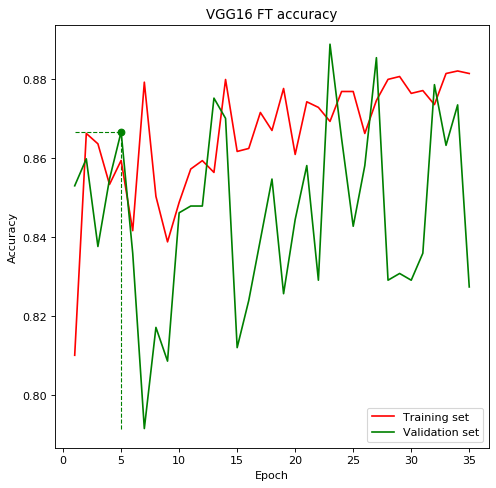

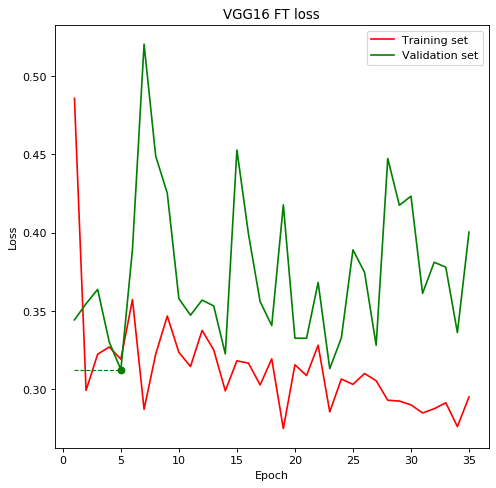

In [32]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adadelta

In [33]:
vgg16_calc_or_mass_best_Adadelta = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_calc_or_mass_best_Adadelta.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_calc_or_mass_best_Adadelta.compile(optimizer=optimizers.Adadelta(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [34]:
# Train
history_vgg16_calc_or_mass_best_Adadelta = vgg16_calc_or_mass_best_Adadelta.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.6477 - recall: 0.5031
Epoch 00001: val_loss improved from inf to 1.38261, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adadelta.h5
11/11 [==============================] - 22s 2s/step - loss: 1.6317 - recall: 0.5064 - val_loss: 1.3826 - val_recall: 0.5265
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.5751 - recall: 0.5234
Epoch 00002: val_loss did not improve from 1.38261
11/11 [==============================] - 21s 2s/step - loss: 1.5607 - recall: 0.5256 - val_loss: 1.4093 - val_recall: 0.5026
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.6476 - recall: 0.4836
Epoch 00003: val_loss improved from 1.38261 to 1.26534, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adadelta.h5
11/11 [==============================] - 22s 2s/step - loss: 1.6203 - recal

Epoch 56/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0379 - recall: 0.5396
Epoch 00056: val_loss did not improve from 0.77251
11/11 [==============================] - 20s 2s/step - loss: 1.0606 - recall: 0.5486 - val_loss: 0.8901 - val_recall: 0.5402
Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0664 - recall: 0.5648
Epoch 00057: val_loss did not improve from 0.77251
11/11 [==============================] - 21s 2s/step - loss: 1.0626 - recall: 0.5623 - val_loss: 0.8938 - val_recall: 0.5692
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0988 - recall: 0.5492
Epoch 00058: val_loss improved from 0.77251 to 0.76405, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adadelta.h5
11/11 [==============================] - 22s 2s/step - loss: 1.1157 - recall: 0.5509 - val_loss: 0.7641 - val_recall: 0.5778
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0931 - recall: 0.5606
Epoch 00059: val_l

Epoch 116/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0603 - recall: 0.5656
Epoch 00116: val_loss improved from 0.73425 to 0.71112, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adadelta.h5
11/11 [==============================] - 23s 2s/step - loss: 1.0480 - recall: 0.5696 - val_loss: 0.7111 - val_recall: 0.6615
Epoch 117/300
10/11 [==========================>...] - ETA: 2:04 - loss: 1.0872 - recall: 0.5598
Epoch 00117: val_loss did not improve from 0.71112
11/11 [==============================] - 1257s 114s/step - loss: 1.0851 - recall: 0.5631 - val_loss: 0.8635 - val_recall: 0.6120
Epoch 118/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0371 - recall: 0.5724
Epoch 00118: val_loss did not improve from 0.71112
11/11 [==============================] - 21s 2s/step - loss: 1.0244 - recall: 0.5729 - val_loss: 0.8195 - val_recall: 0.6068
Epoch 119/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9679 - recall: 0.5800
Epoch 00

Epoch 146/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0663 - recall: 0.5797
Epoch 00146: val_loss did not improve from 0.69517
11/11 [==============================] - 22s 2s/step - loss: 1.0819 - recall: 0.5795 - val_loss: 0.7893 - val_recall: 0.6667
Epoch 147/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9041 - recall: 0.6111
Epoch 00147: val_loss did not improve from 0.69517
11/11 [==============================] - 20s 2s/step - loss: 0.9251 - recall: 0.6079 - val_loss: 0.7410 - val_recall: 0.6479
Epoch 148/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9950 - recall: 0.5943
Epoch 00148: val_loss did not improve from 0.69517
11/11 [==============================] - 21s 2s/step - loss: 0.9944 - recall: 0.5904 - val_loss: 0.7152 - val_recall: 0.6462
Epoch 149/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9546 - recall: 0.6031
Epoch 00149: val_loss did not improve from 0.69517
11/11 [==============================] - 

Epoch 176/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9825 - recall: 0.5875
Epoch 00176: val_loss improved from 0.67219 to 0.66641, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adadelta.h5
11/11 [==============================] - 21s 2s/step - loss: 1.0006 - recall: 0.5874 - val_loss: 0.6664 - val_recall: 0.6855
Epoch 177/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9819 - recall: 0.5992
Epoch 00177: val_loss did not improve from 0.66641
11/11 [==============================] - 22s 2s/step - loss: 0.9958 - recall: 0.5930 - val_loss: 0.7900 - val_recall: 0.6393
Epoch 178/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9176 - recall: 0.6052
Epoch 00178: val_loss did not improve from 0.66641
11/11 [==============================] - 20s 2s/step - loss: 0.9216 - recall: 0.6079 - val_loss: 0.7456 - val_recall: 0.6957
Epoch 179/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9648 - recall: 0.6109
Epoch 00179: v

Epoch 206/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9762 - recall: 0.6019
Epoch 00206: val_loss did not improve from 0.63767
11/11 [==============================] - 21s 2s/step - loss: 0.9782 - recall: 0.6011 - val_loss: 0.7594 - val_recall: 0.6632
Epoch 207/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9536 - recall: 0.6187
Epoch 00207: val_loss did not improve from 0.63767
11/11 [==============================] - 22s 2s/step - loss: 0.9347 - recall: 0.6222 - val_loss: 0.7082 - val_recall: 0.6667
Epoch 208/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9510 - recall: 0.6180
Epoch 00208: val_loss did not improve from 0.63767
11/11 [==============================] - 21s 2s/step - loss: 0.9740 - recall: 0.6058 - val_loss: 0.7172 - val_recall: 0.6803
Epoch 209/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9575 - recall: 0.5993
Epoch 00209: val_loss did not improve from 0.63767
11/11 [==============================] - 

In [35]:
models.save_model(vgg16_calc_or_mass_best_Adadelta, '../model/vgg16_calc_or_mass_end_Adadelta.h5')

In [36]:
tra_loss_fe = history_vgg16_calc_or_mass_best_Adadelta.history['loss']
tra_acc_fe = history_vgg16_calc_or_mass_best_Adadelta.history['recall']
val_loss_fe = history_vgg16_calc_or_mass_best_Adadelta.history['val_loss']
val_acc_fe = history_vgg16_calc_or_mass_best_Adadelta.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_calc_or_mass = models.load_model('../model/vgg16_calc_or_mass_best_Adadelta.h5')
test_loss_fe, test_acc_fe = vgg16_calc_or_mass_best_Adadelta.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG16 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 229
Epoch [opt]: 199
Valid accuracy [end]: 0.6718
Valid accuracy [opt]: 0.7111
Test accuracy [end]:  0.6827
Test accuracy [opt]:  0.6796
Valid loss [end]: 0.7117
Valid loss [opt]: 0.6377
Test loss [end]:  0.7267
Test loss [opt]:  0.7441


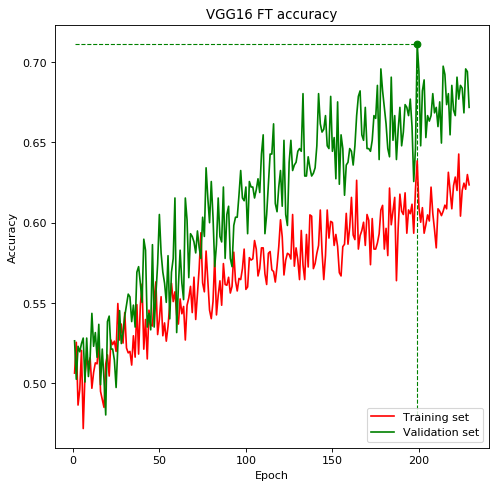

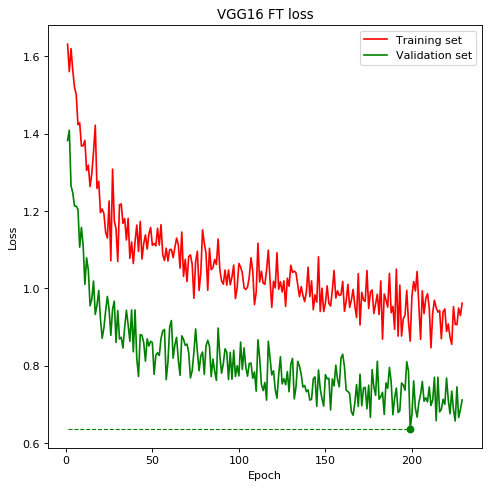

In [37]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adagrad

In [13]:
vgg16_calc_or_mass_best_Adagrad = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_calc_or_mass_best_Adagrad.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_calc_or_mass_best_Adagrad.compile(optimizer=optimizers.Adagrad(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [14]:
# Train
history_vgg16_calc_or_mass_best_Adagrad = vgg16_calc_or_mass_best_Adagrad.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2366 - recall: 0.5556
Epoch 00001: val_loss improved from inf to 0.87093, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adagrad.h5
11/11 [==============================] - 24s 2s/step - loss: 1.2445 - recall: 0.5562 - val_loss: 0.8709 - val_recall: 0.6239
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0926 - recall: 0.5699
Epoch 00002: val_loss improved from 0.87093 to 0.82208, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adagrad.h5
11/11 [==============================] - 21s 2s/step - loss: 1.0994 - recall: 0.5646 - val_loss: 0.8221 - val_recall: 0.6222
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0711 - recall: 0.5906
Epoch 00003: val_loss improved from 0.82208 to 0.818

Epoch 55/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6208 - recall: 0.7315
Epoch 00055: val_loss did not improve from 0.48283
11/11 [==============================] - 21s 2s/step - loss: 0.6210 - recall: 0.7363 - val_loss: 0.4955 - val_recall: 0.7624
Epoch 56/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6371 - recall: 0.7422
Epoch 00056: val_loss did not improve from 0.48283
11/11 [==============================] - 22s 2s/step - loss: 0.6384 - recall: 0.7386 - val_loss: 0.5385 - val_recall: 0.7744
Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6281 - recall: 0.7180
Epoch 00057: val_loss improved from 0.48283 to 0.47398, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adagrad.h5
11/11 [==============================] - 21s 2s/step - loss: 0.6224 - recall: 0.7226 - val_loss: 0.4740 - val_recall: 0.7932
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6362 - recall: 0.7445
Epoch 00058: val_lo

Epoch 85/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5848 - recall: 0.7677
Epoch 00085: val_loss improved from 0.45485 to 0.45407, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adagrad.h5
11/11 [==============================] - 22s 2s/step - loss: 0.5901 - recall: 0.7599 - val_loss: 0.4541 - val_recall: 0.7949
Epoch 86/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6316 - recall: 0.7383
Epoch 00086: val_loss improved from 0.45407 to 0.45074, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adagrad.h5
11/11 [==============================] - 22s 2s/step - loss: 0.6322 - recall: 0.7393 - val_loss: 0.4507 - val_recall: 0.8068
Epoch 87/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6147 - recall: 0.7383
Epoch 00087: val_loss did not improve from 0.45074
11/11 [==============================] - 21s 2s/step - loss: 0.6074 - recall: 0.7379 - val_loss: 0.4593 - val_recall: 0.7795
Epoch 88/300
10/11 [================

Epoch 115/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5775 - recall: 0.7609
Epoch 00115: val_loss did not improve from 0.42584
11/11 [==============================] - 21s 2s/step - loss: 0.5755 - recall: 0.7561 - val_loss: 0.4449 - val_recall: 0.7915
Epoch 116/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5956 - recall: 0.7542
Epoch 00116: val_loss did not improve from 0.42584
11/11 [==============================] - 21s 2s/step - loss: 0.5906 - recall: 0.7553 - val_loss: 0.4743 - val_recall: 0.7863
Epoch 117/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5823 - recall: 0.7399
Epoch 00117: val_loss did not improve from 0.42584
11/11 [==============================] - 21s 2s/step - loss: 0.5950 - recall: 0.7394 - val_loss: 0.4643 - val_recall: 0.7761
Epoch 118/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6088 - recall: 0.7539
Epoch 00118: val_loss did not improve from 0.42584
11/11 [==============================] - 

Epoch 145/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6351 - recall: 0.7458
Epoch 00145: val_loss did not improve from 0.41368
11/11 [==============================] - 21s 2s/step - loss: 0.6256 - recall: 0.7470 - val_loss: 0.4267 - val_recall: 0.8256
Epoch 146/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5354 - recall: 0.7805
Epoch 00146: val_loss did not improve from 0.41368
11/11 [==============================] - 21s 2s/step - loss: 0.5296 - recall: 0.7804 - val_loss: 0.4650 - val_recall: 0.7983
Epoch 147/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5685 - recall: 0.7643
Epoch 00147: val_loss did not improve from 0.41368
11/11 [==============================] - 20s 2s/step - loss: 0.5631 - recall: 0.7622 - val_loss: 0.4774 - val_recall: 0.7932
Epoch 148/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5337 - recall: 0.7694
Epoch 00148: val_loss did not improve from 0.41368
11/11 [==============================] - 

In [15]:
models.save_model(vgg16_calc_or_mass_best_Adagrad, '../model/vgg16_calc_or_mass_end_Adagrad.h5')

In [16]:
tra_loss_fe = history_vgg16_calc_or_mass_best_Adagrad.history['loss']
tra_acc_fe = history_vgg16_calc_or_mass_best_Adagrad.history['recall']
val_loss_fe = history_vgg16_calc_or_mass_best_Adagrad.history['val_loss']
val_acc_fe = history_vgg16_calc_or_mass_best_Adagrad.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_calc_or_mass = models.load_model('../model/vgg16_calc_or_mass_best_Adagrad.h5')
test_loss_fe, test_acc_fe = vgg16_calc_or_mass_best_Adagrad.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG16 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 156
Epoch [opt]: 126
Valid accuracy [end]: 0.7915
Valid accuracy [opt]: 0.8274
Test accuracy [end]:  0.7932
Test accuracy [opt]:  0.7760
Valid loss [end]: 0.4541
Valid loss [opt]: 0.4137
Test loss [end]:  0.4494
Test loss [opt]:  0.4720


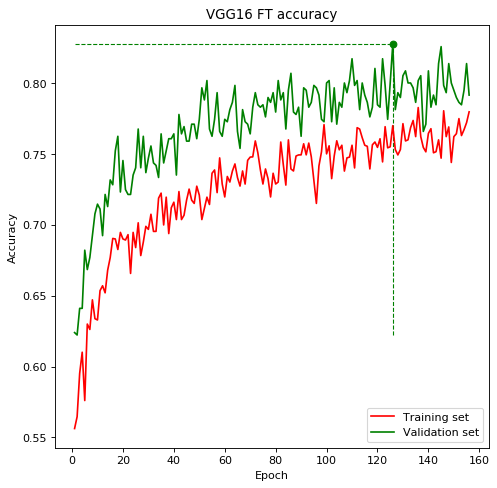

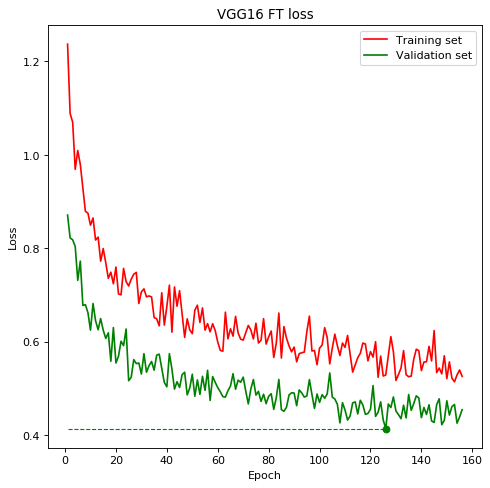

In [17]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adamax

In [18]:
vgg16_calc_or_mass_best_Adamax = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_calc_or_mass_best_Adamax.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_calc_or_mass_best_Adamax.compile(optimizer=optimizers.Adamax(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [19]:
# Train
history_vgg16_calc_or_mass_best_Adamax = vgg16_calc_or_mass_best_Adamax.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1135 - recall: 0.6297
Epoch 00001: val_loss improved from inf to 0.83800, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adamax.h5
11/11 [==============================] - 22s 2s/step - loss: 1.0726 - recall: 0.6428 - val_loss: 0.8380 - val_recall: 0.7231
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8810 - recall: 0.7141
Epoch 00002: val_loss improved from 0.83800 to 0.66518, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adamax.h5
11/11 [==============================] - 23s 2s/step - loss: 0.8944 - recall: 0.7109 - val_loss: 0.6652 - val_recall: 0.7726
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7773 - recall: 0.7344
Epoch 00003: val_loss improved from 0.66518 to 0.53460, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adamax.h5
11/

Epoch 27/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5036 - recall: 0.8047
Epoch 00027: val_loss did not improve from 0.37086
11/11 [==============================] - 21s 2s/step - loss: 0.4940 - recall: 0.8070 - val_loss: 0.4214 - val_recall: 0.8308
Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4600 - recall: 0.8089
Epoch 00028: val_loss did not improve from 0.37086
11/11 [==============================] - 21s 2s/step - loss: 0.4607 - recall: 0.8040 - val_loss: 0.3933 - val_recall: 0.8154
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4817 - recall: 0.8055
Epoch 00029: val_loss improved from 0.37086 to 0.36835, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adamax.h5
11/11 [==============================] - 22s 2s/step - loss: 0.4786 - recall: 0.8047 - val_loss: 0.3684 - val_recall: 0.8256
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4313 - recall: 0.8078
Epoch 00030: val_los

10/11 [==========================>...] - ETA: 1s - loss: 0.4104 - recall: 0.8141
Epoch 00086: val_loss did not improve from 0.31866
11/11 [==============================] - 22s 2s/step - loss: 0.4120 - recall: 0.8153 - val_loss: 0.3524 - val_recall: 0.8359
Epoch 87/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4121 - recall: 0.8182
Epoch 00087: val_loss did not improve from 0.31866
11/11 [==============================] - 20s 2s/step - loss: 0.4094 - recall: 0.8199 - val_loss: 0.3592 - val_recall: 0.8444
Epoch 88/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3821 - recall: 0.8266
Epoch 00088: val_loss improved from 0.31866 to 0.31490, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adamax.h5
11/11 [==============================] - 23s 2s/step - loss: 0.3801 - recall: 0.8288 - val_loss: 0.3149 - val_recall: 0.8581
Epoch 89/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3952 - recall: 0.8305
Epoch 00089: val_loss did not imp

Epoch 116/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3643 - recall: 0.8409
Epoch 00116: val_loss did not improve from 0.30452
11/11 [==============================] - 21s 2s/step - loss: 0.3637 - recall: 0.8412 - val_loss: 0.3247 - val_recall: 0.8513
Epoch 117/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3457 - recall: 0.8500
Epoch 00117: val_loss did not improve from 0.30452
11/11 [==============================] - 22s 2s/step - loss: 0.3532 - recall: 0.8480 - val_loss: 0.3416 - val_recall: 0.8581
Epoch 118/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3713 - recall: 0.8325
Epoch 00118: val_loss did not improve from 0.30452
11/11 [==============================] - 20s 2s/step - loss: 0.3656 - recall: 0.8336 - val_loss: 0.3324 - val_recall: 0.8598
Epoch 119/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3635 - recall: 0.8350
Epoch 00119: val_loss did not improve from 0.30452
11/11 [==============================] - 

In [20]:
models.save_model(vgg16_calc_or_mass_best_Adamax, '../model/vgg16_calc_or_mass_end_Adamax.h5')

In [21]:
tra_loss_fe = history_vgg16_calc_or_mass_best_Adamax.history['loss']
tra_acc_fe = history_vgg16_calc_or_mass_best_Adamax.history['recall']
val_loss_fe = history_vgg16_calc_or_mass_best_Adamax.history['val_loss']
val_acc_fe = history_vgg16_calc_or_mass_best_Adamax.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_calc_or_mass = models.load_model('../model/vgg16_calc_or_mass_best_Adamax.h5')
test_loss_fe, test_acc_fe = vgg16_calc_or_mass_best_Adamax.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG16 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 122
Epoch [opt]: 92
Valid accuracy [end]: 0.8598
Valid accuracy [opt]: 0.8769
Test accuracy [end]:  0.8725
Test accuracy [opt]:  0.8647
Valid loss [end]: 0.3124
Valid loss [opt]: 0.3045
Test loss [end]:  0.2982
Test loss [opt]:  0.3300


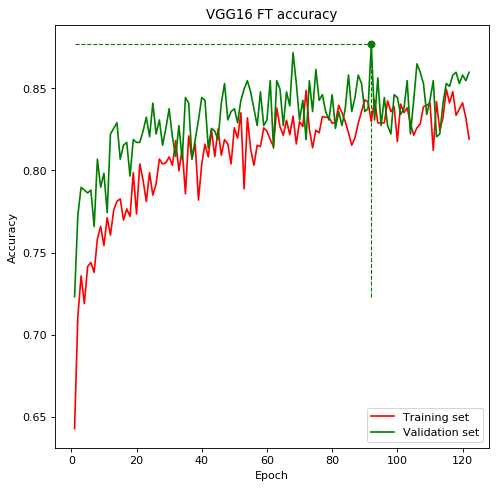

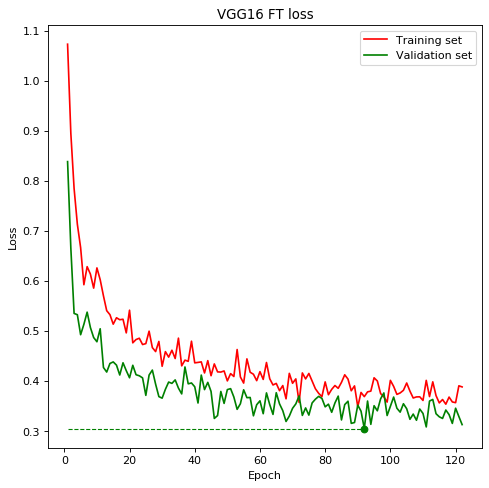

In [22]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

## Nadam

In [12]:
vgg16_calc_or_mass_best_Nadam = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_calc_or_mass_best_Nadam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_calc_or_mass_best_Nadam.compile(optimizer=optimizers.Nadam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [13]:
# Train
history_vgg16_calc_or_mass_best_Nadam = vgg16_calc_or_mass_best_Nadam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4000 - recall: 0.5918
Epoch 00001: val_loss improved from inf to 0.62052, saving model to ../model/vgg16_mass_benign_or_malignant_best_Nadam.h5
11/11 [==============================] - 24s 2s/step - loss: 1.3258 - recall: 0.6056 - val_loss: 0.6205 - val_recall: 0.7265
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7189 - recall: 0.7031
Epoch 00002: val_loss improved from 0.62052 to 0.50569, saving model to ../model/vgg16_mass_benign_or_malignant_best_Nadam.h5
11/11 [==============================] - 22s 2s/step - loss: 0.7180 - recall: 0.7031 - val_loss: 0.5057 - val_recall: 0.7778
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6315 - recall: 0.7242
Epoch 00003: val_loss did not improve from 0.50569
11/11

Epoch 55/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3222 - recall: 0.8516
Epoch 00055: val_loss did not improve from 0.28748
11/11 [==============================] - 20s 2s/step - loss: 0.3293 - recall: 0.8503 - val_loss: 0.3805 - val_recall: 0.8393
Epoch 56/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3615 - recall: 0.8344
Epoch 00056: val_loss did not improve from 0.28748
11/11 [==============================] - 21s 2s/step - loss: 0.3597 - recall: 0.8331 - val_loss: 0.3209 - val_recall: 0.8427
Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3260 - recall: 0.8561
Epoch 00057: val_loss did not improve from 0.28748
11/11 [==============================] - 20s 2s/step - loss: 0.3408 - recall: 0.8511 - val_loss: 0.3366 - val_recall: 0.8496
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3359 - recall: 0.8460
Epoch 00058: val_loss did not improve from 0.28748
11/11 [==============================] - 21s 

In [14]:
models.save_model(vgg16_calc_or_mass_best_Nadam, '../model/vgg16_calc_or_mass_end_Nadam.h5')

In [15]:
tra_loss_fe = history_vgg16_calc_or_mass_best_Nadam.history['loss']
tra_acc_fe = history_vgg16_calc_or_mass_best_Nadam.history['recall']
val_loss_fe = history_vgg16_calc_or_mass_best_Nadam.history['val_loss']
val_acc_fe = history_vgg16_calc_or_mass_best_Nadam.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_calc_or_mass = models.load_model('../model/vgg16_calc_or_mass_best_Nadam.h5')
test_loss_fe, test_acc_fe = vgg16_calc_or_mass_best_Nadam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG16 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 68
Epoch [opt]: 38
Valid accuracy [end]: 0.8513
Valid accuracy [opt]: 0.8752
Test accuracy [end]:  0.8740
Test accuracy [opt]:  0.8896
Valid loss [end]: 0.3279
Valid loss [opt]: 0.2875
Test loss [end]:  0.2910
Test loss [opt]:  0.2776


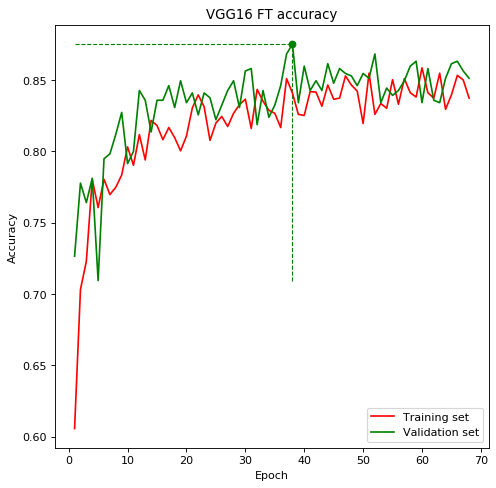

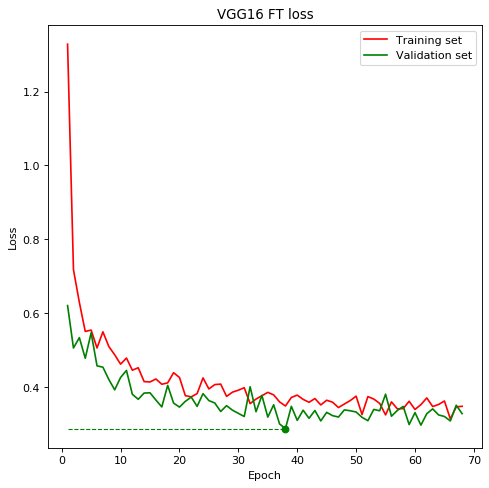

In [16]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#### fine tuning

In [11]:
vgg16_calc_or_mass_fine_Adam = models.load_model('../model/vgg16_calc_or_mass_best_Adam.h5')

for layer in vgg16_calc_or_mass_fine_Adam.layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_calc_or_mass_fine_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg16_calc_or_mass_fine_Adam.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [12]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg16_calc_or_mass_fine_Adam_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [13]:
history_fit = vgg16_calc_or_mass_fine_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3225 - recall: 0.8539
Epoch 00001: val_loss improved from inf to 0.36487, saving model to ../model/vgg16_mass_benign_or_malignant_fine_Adam_best.h5
11/11 [==============================] - 25s 2s/step - loss: 0.3263 - recall: 0.8509 - val_loss: 0.3649 - val_recall: 0.8274
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2926 - recall: 0.8746
Epoch 00002: val_loss improved from 0.36487 to 0.31961, saving model to ../model/vgg16_mass_benign_or_malignant_fine_Adam_best.h5
11/11 [==============================] - 20s 2s/step - loss: 0.2991 - recall: 0.8708 - val_loss: 0.3196 - val_recall: 0.8632
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2979 - recall: 0.8712
Epoch 00003: val_loss improved from 0.31961 to 0

Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2502 - recall: 0.8984
Epoch 00028: val_loss did not improve from 0.27285
11/11 [==============================] - 22s 2s/step - loss: 0.2550 - recall: 0.8956 - val_loss: 0.2889 - val_recall: 0.8838
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2410 - recall: 0.8984
Epoch 00029: val_loss improved from 0.27285 to 0.26275, saving model to ../model/vgg16_mass_benign_or_malignant_fine_Adam_best.h5
11/11 [==============================] - 20s 2s/step - loss: 0.2388 - recall: 0.8982 - val_loss: 0.2627 - val_recall: 0.8940
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2258 - recall: 0.9082
Epoch 00030: val_loss improved from 0.26275 to 0.25805, saving model to ../model/vgg16_mass_benign_or_malignant_fine_Adam_best.h5
11/11 [==============================] - 20s 2s/step - loss: 0.2317 - recall: 0.9065 - val_loss: 0.2580 - val_recall: 0.8838
Epoch 31/300
10/11 [============

Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1995 - recall: 0.9167
Epoch 00057: val_loss did not improve from 0.24356
11/11 [==============================] - 20s 2s/step - loss: 0.2103 - recall: 0.9149 - val_loss: 0.2875 - val_recall: 0.8906
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2312 - recall: 0.8973
Epoch 00058: val_loss did not improve from 0.24356
11/11 [==============================] - 21s 2s/step - loss: 0.2308 - recall: 0.8974 - val_loss: 0.2645 - val_recall: 0.8838
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2222 - recall: 0.9055
Epoch 00059: val_loss did not improve from 0.24356
11/11 [==============================] - 22s 2s/step - loss: 0.2152 - recall: 0.9084 - val_loss: 0.2892 - val_recall: 0.8855
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2194 - recall: 0.9057
Epoch 00060: val_loss did not improve from 0.24356
11/11 [==============================] - 20s 

10/11 [==========================>...] - ETA: 1s - loss: 0.1679 - recall: 0.9312
Epoch 00117: val_loss did not improve from 0.21710
11/11 [==============================] - 22s 2s/step - loss: 0.1682 - recall: 0.9311 - val_loss: 0.2553 - val_recall: 0.9009
Epoch 00117: early stopping


In [14]:
models.save_model(vgg16_calc_or_mass_fine_Adam, '../model/vgg16_calc_or_mass_fine_Adam_end.h5')

In [15]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_calc_or_mass_fine_Adam = models.load_model('../model/vgg16_calc_or_mass_fine_Adam_best.h5')
test_loss_fe, test_acc_fe = vgg16_calc_or_mass_fine_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_or_mass_fine_Adam.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 117
Epoch [opt]: 87
Valid accuracy [end]: 0.9009
Valid accuracy [opt]: 0.9128
Test accuracy [end]:  0.9191
Test accuracy [opt]:  0.9051
Valid loss [end]: 0.2553
Valid loss [opt]: 0.2171
Test loss [end]:  0.2318
Test loss [opt]:  0.2383


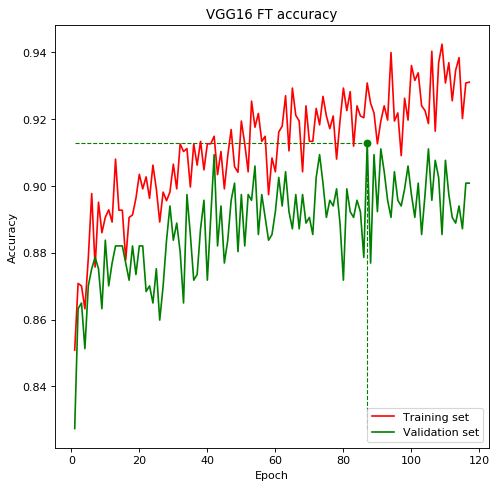

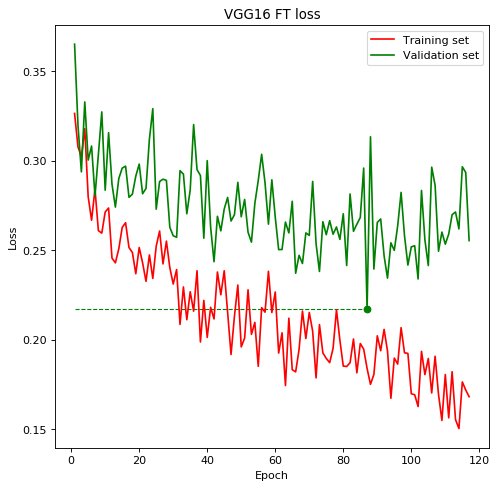

In [16]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [18]:
vgg16_calc_or_mass_fine_Adam2 = models.load_model('../model/vgg16_calc_or_mass_fine_Adam_best.h5')

for layer in vgg16_calc_or_mass_fine_Adam2.layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_calc_or_mass_fine_Adam2.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg16_calc_or_mass_fine_Adam.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [19]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg16_calc_or_mass_fine_Adam_best2.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [20]:
history_fit = vgg16_calc_or_mass_fine_Adam2.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2375 - recall: 0.8953
Epoch 00001: val_loss improved from inf to 0.29137, saving model to ../model/vgg16_mass_benign_or_malignant_fine_Adam_best2.h5
11/11 [==============================] - 22s 2s/step - loss: 0.2310 - recall: 0.8991 - val_loss: 0.2914 - val_recall: 0.8735
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2314 - recall: 0.8939
Epoch 00002: val_loss did not improve from 0.29137
11/11 [==============================] - 21s 2s/step - loss: 0.2255 - recall: 0.8989 - val_loss: 0.3091 - val_recall: 0.8940
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2410 - recall: 0.9078
Epoch 00003: val_loss improved from 0.29137 to 0.28690, saving model to ../model/vgg16_mass_benign_or_malignant_fine_Adam_best2.h5
11/11 [==============================] - 22s 2s/step - loss: 0.2363 - r

In [21]:
models.save_model(vgg16_calc_or_mass_fine_Adam2, '../model/vgg16_calc_or_mass_fine_Adam_end2.h5')

In [22]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_calc_or_mass_fine_Adam2 = models.load_model('../model/vgg16_calc_or_mass_fine_Adam_best2.h5')
test_loss_fe, test_acc_fe = vgg16_calc_or_mass_fine_Adam2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_or_mass_fine_Adam2.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 53
Epoch [opt]: 23
Valid accuracy [end]: 0.9009
Valid accuracy [opt]: 0.9179
Test accuracy [end]:  0.9160
Test accuracy [opt]:  0.9160
Valid loss [end]: 0.2419
Valid loss [opt]: 0.2097
Test loss [end]:  0.2438
Test loss [opt]:  0.2403


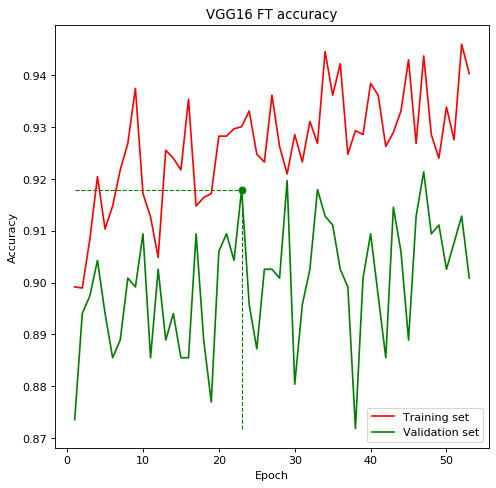

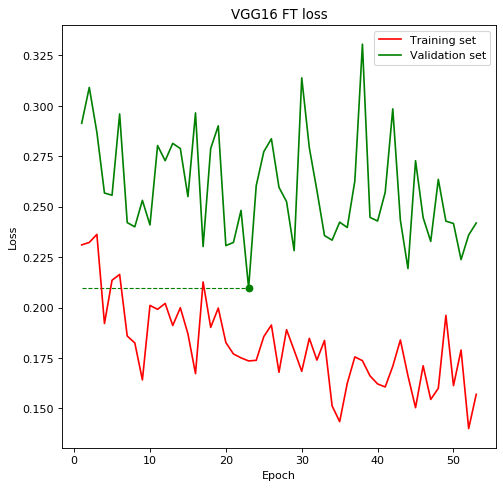

In [23]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [24]:
vgg16_calc_or_mass_fine_Adam3 = models.load_model('../model/vgg16_calc_or_mass_fine_Adam_best2.h5')

for layer in vgg16_calc_or_mass_fine_Adam3.layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_calc_or_mass_fine_Adam3.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg16_calc_or_mass_fine_Adam3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [25]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg16_calc_or_mass_fine_Adam_best3.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [26]:
history_fit = vgg16_calc_or_mass_fine_Adam3.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4100 - recall: 0.8325
Epoch 00001: val_loss improved from inf to 0.35346, saving model to ../model/vgg16_mass_benign_or_malignant_fine_Adam_best3.h5
11/11 [==============================] - 21s 2s/step - loss: 0.4020 - recall: 0.8359 - val_loss: 0.3535 - val_recall: 0.8308
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2936 - recall: 0.8645
Epoch 00002: val_loss improved from 0.35346 to 0.29797, saving model to ../model/vgg16_mass_benign_or_malignant_fine_Adam_best3.h5
11/11 [==============================] - 21s 2s/step - loss: 0.2952 - recall: 0.8663 - val_loss: 0.2980 - val_recall: 0.8650
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2422 - recall: 0.8880
Epoch 00003: val_loss improved from 0.29797 to 0.27240, saving model to ../model/vgg16_mass_benign_or_malignant_fine_Adam_

Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1393 - recall: 0.9461
Epoch 00029: val_loss did not improve from 0.21245
11/11 [==============================] - 20s 2s/step - loss: 0.1376 - recall: 0.9460 - val_loss: 0.2408 - val_recall: 0.9179
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1668 - recall: 0.9273
Epoch 00030: val_loss did not improve from 0.21245
11/11 [==============================] - 21s 2s/step - loss: 0.1663 - recall: 0.9304 - val_loss: 0.2500 - val_recall: 0.9128
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1569 - recall: 0.9367
Epoch 00031: val_loss did not improve from 0.21245
11/11 [==============================] - 21s 2s/step - loss: 0.1534 - recall: 0.9389 - val_loss: 0.2821 - val_recall: 0.9060
Epoch 32/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1506 - recall: 0.9301
Epoch 00032: val_loss did not improve from 0.21245
11/11 [==============================] - 20s 

In [27]:
models.save_model(vgg16_calc_or_mass_fine_Adam3, '../model/vgg16_calc_or_mass_fine_Adam_end3.h5')

In [28]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_calc_or_mass_fine_Adam3 = models.load_model('../model/vgg16_calc_or_mass_fine_Adam_best3.h5')
test_loss_fe, test_acc_fe = vgg16_calc_or_mass_fine_Adam3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_or_mass_fine_Adam3.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 41
Epoch [opt]: 11
Valid accuracy [end]: 0.9111
Valid accuracy [opt]: 0.9077
Test accuracy [end]:  0.9316
Test accuracy [opt]:  0.9207
Valid loss [end]: 0.2715
Valid loss [opt]: 0.2124
Test loss [end]:  0.2195
Test loss [opt]:  0.2119


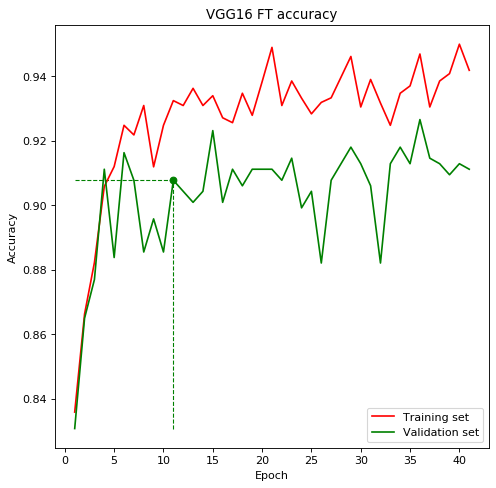

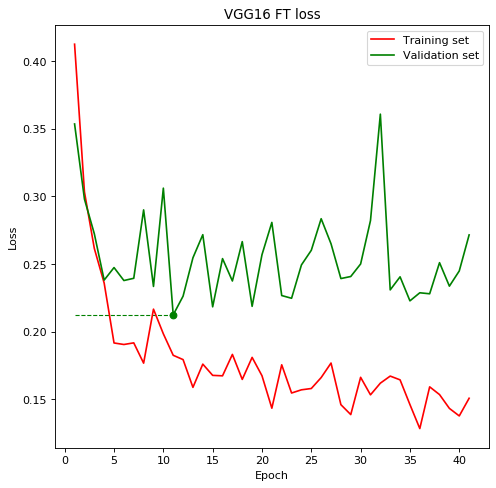

In [29]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();